# 06: Model Improvement - Quick Wins

**Author**: Nate DeMoro  
**Date**: January 2026

## Objective
Improve the Random Forest model from R²=0.56 toward R²>0.70 using three "quick win" strategies:

1. **Log-transform target variable** - Address heteroscedasticity (errors scale with revenue)
2. **Aggressive regularization** - Reduce overfitting (train R²=0.95 → test R²=0.56 gap)
3. **Feature reduction** - Remove low-importance features (<1% importance)

## Current State
- Best model: Random Forest (Test R²=0.56, Train R²=0.95, MAE=$89M)
- Overfitting gap: 0.39 (severe)
- Top 3 features explain 52% of importance

## 1. Setup and Data Loading

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import randint, uniform
import joblib

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Load the pre-split data (from notebook 04)
X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').squeeze()
y_test = pd.read_csv('../data/processed/y_test.csv').squeeze()

# Load feature importance for feature selection
feature_importance = pd.read_csv('../data/processed/feature_importance_all_models.csv')

print(f"Training set: {X_train.shape[0]:,} movies, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]:,} movies, {X_test.shape[1]} features")
print(f"\nTarget (revenue_worldwide):")
print(f"  Train range: ${y_train.min():,.0f} - ${y_train.max():,.0f}")
print(f"  Test range: ${y_test.min():,.0f} - ${y_test.max():,.0f}")

Training set: 1,682 movies, 28 features
Test set: 413 movies, 28 features

Target (revenue_worldwide):
  Train range: $1,532 - $2,799,439,100
  Test range: $1,281 - $2,334,484,620


## 2. Baseline: Current Best Model

First, let's establish the baseline by loading and evaluating the current best Random Forest model.

In [3]:
# Load the current best model
rf_original = joblib.load('../models/random_forest_tuned.pkl')

# Evaluate baseline
y_train_pred_orig = rf_original.predict(X_train)
y_test_pred_orig = rf_original.predict(X_test)

baseline_results = {
    'Model': 'RF Original (Baseline)',
    'Train_R2': r2_score(y_train, y_train_pred_orig),
    'Test_R2': r2_score(y_test, y_test_pred_orig),
    'Train_MAE_M': mean_absolute_error(y_train, y_train_pred_orig) / 1e6,
    'Test_MAE_M': mean_absolute_error(y_test, y_test_pred_orig) / 1e6,
}
baseline_results['Overfit_Gap'] = baseline_results['Train_R2'] - baseline_results['Test_R2']

print("=" * 60)
print("BASELINE: Original Random Forest (from notebook 05)")
print("=" * 60)
print(f"Train R²: {baseline_results['Train_R2']:.4f}")
print(f"Test R²:  {baseline_results['Test_R2']:.4f}")
print(f"Overfitting Gap: {baseline_results['Overfit_Gap']:.4f}")
print(f"Train MAE: ${baseline_results['Train_MAE_M']:.1f}M")
print(f"Test MAE:  ${baseline_results['Test_MAE_M']:.1f}M")

BASELINE: Original Random Forest (from notebook 05)
Train R²: 0.9480
Test R²:  0.5593
Overfitting Gap: 0.3887
Train MAE: $29.4M
Test MAE:  $88.8M


## 3. Improvement 1: Log-Transform Target Variable

### Why?
The revenue distribution is highly skewed (ranges from ~$700K to $2.3B). This causes:
- **Heteroscedasticity**: Errors increase with revenue magnitude
- **Blockbuster dominance**: Large movies disproportionately affect the loss function
- **Small film overprediction**: Model overpredicts low-budget films

Log-transformation compresses the scale, making the distribution more normal and errors more homoscedastic.

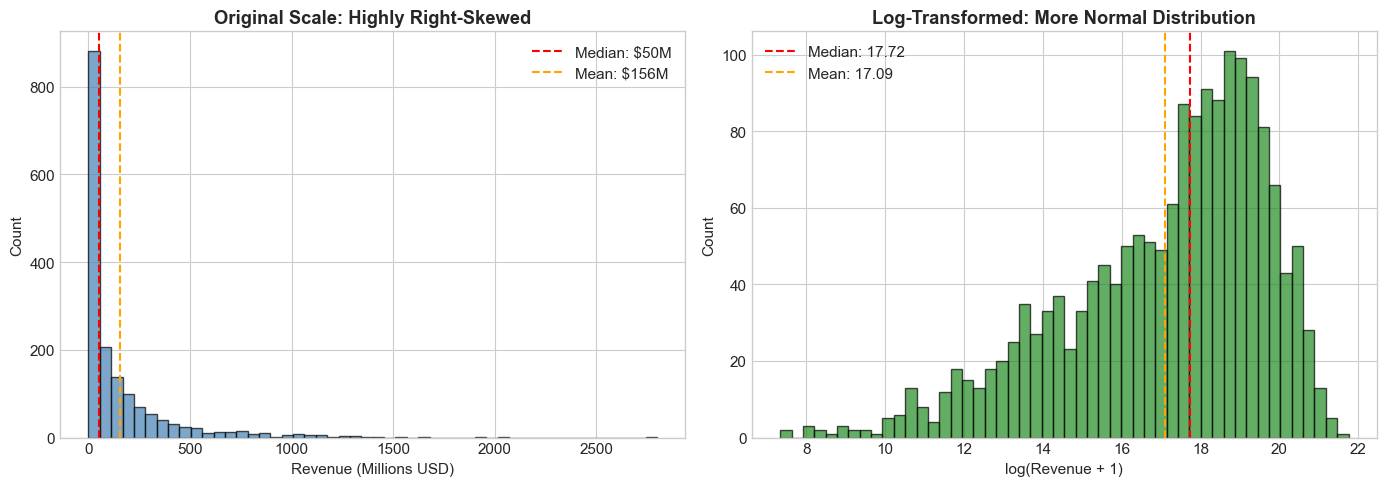


Skewness - Original: 3.30
Skewness - Log-transformed: -0.89


In [4]:
# Visualize the current distribution vs log-transformed
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original scale
axes[0].hist(y_train / 1e6, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Revenue (Millions USD)')
axes[0].set_ylabel('Count')
axes[0].set_title('Original Scale: Highly Right-Skewed', fontweight='bold')
axes[0].axvline(y_train.median() / 1e6, color='red', linestyle='--', label=f'Median: ${y_train.median()/1e6:.0f}M')
axes[0].axvline(y_train.mean() / 1e6, color='orange', linestyle='--', label=f'Mean: ${y_train.mean()/1e6:.0f}M')
axes[0].legend()

# Log-transformed
y_train_log = np.log1p(y_train)
axes[1].hist(y_train_log, bins=50, edgecolor='black', alpha=0.7, color='forestgreen')
axes[1].set_xlabel('log(Revenue + 1)')
axes[1].set_ylabel('Count')
axes[1].set_title('Log-Transformed: More Normal Distribution', fontweight='bold')
axes[1].axvline(y_train_log.median(), color='red', linestyle='--', label=f'Median: {y_train_log.median():.2f}')
axes[1].axvline(y_train_log.mean(), color='orange', linestyle='--', label=f'Mean: {y_train_log.mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('../visualizations/06_log_transform_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSkewness - Original: {y_train.skew():.2f}")
print(f"Skewness - Log-transformed: {y_train_log.skew():.2f}")

In [5]:
# Apply log transformation
y_train_log = np.log1p(y_train)  # log1p = log(1 + x), handles edge cases
y_test_log = np.log1p(y_test)

print("Log-transformed target:")
print(f"  y_train_log range: {y_train_log.min():.2f} - {y_train_log.max():.2f}")
print(f"  y_test_log range: {y_test_log.min():.2f} - {y_test_log.max():.2f}")

Log-transformed target:
  y_train_log range: 7.33 - 21.75
  y_test_log range: 7.16 - 21.57


In [6]:
# Train Random Forest on log-transformed target (using same hyperparameters as original)
rf_log = RandomForestRegressor(
    n_estimators=rf_original.n_estimators,
    max_depth=rf_original.max_depth,
    min_samples_split=rf_original.min_samples_split,
    min_samples_leaf=rf_original.min_samples_leaf,
    max_features=rf_original.max_features,
    random_state=42,
    n_jobs=-1
)

print("Training RF on log-transformed target...")
rf_log.fit(X_train, y_train_log)

# Predict in log space
y_train_pred_log = rf_log.predict(X_train)
y_test_pred_log = rf_log.predict(X_test)

# Convert back to original scale for evaluation
y_train_pred_exp = np.expm1(y_train_pred_log)  # expm1 = exp(x) - 1, inverse of log1p
y_test_pred_exp = np.expm1(y_test_pred_log)

# Evaluate on ORIGINAL scale (for fair comparison)
log_transform_results = {
    'Model': 'RF + Log-Transform',
    'Train_R2': r2_score(y_train, y_train_pred_exp),
    'Test_R2': r2_score(y_test, y_test_pred_exp),
    'Train_MAE_M': mean_absolute_error(y_train, y_train_pred_exp) / 1e6,
    'Test_MAE_M': mean_absolute_error(y_test, y_test_pred_exp) / 1e6,
}
log_transform_results['Overfit_Gap'] = log_transform_results['Train_R2'] - log_transform_results['Test_R2']

print("\n" + "=" * 60)
print("IMPROVEMENT 1: Log-Transform Target")
print("=" * 60)
print(f"Train R²: {log_transform_results['Train_R2']:.4f} (was {baseline_results['Train_R2']:.4f})")
print(f"Test R²:  {log_transform_results['Test_R2']:.4f} (was {baseline_results['Test_R2']:.4f})")
print(f"Overfitting Gap: {log_transform_results['Overfit_Gap']:.4f} (was {baseline_results['Overfit_Gap']:.4f})")
print(f"Test MAE:  ${log_transform_results['Test_MAE_M']:.1f}M (was ${baseline_results['Test_MAE_M']:.1f}M)")

test_r2_change = log_transform_results['Test_R2'] - baseline_results['Test_R2']
print(f"\n>>> Test R² Change: {test_r2_change:+.4f} ({test_r2_change/baseline_results['Test_R2']*100:+.1f}%)")

Training RF on log-transformed target...

IMPROVEMENT 1: Log-Transform Target
Train R²: 0.8787 (was 0.9480)
Test R²:  0.4131 (was 0.5593)
Overfitting Gap: 0.4657 (was 0.3887)
Test MAE:  $80.8M (was $88.8M)

>>> Test R² Change: -0.1462 (-26.1%)


## 4. Improvement 2: Aggressive Regularization

### Why?
The current model has severe overfitting (Train R²=0.95, Test R²=0.56). This indicates the model is memorizing training data rather than learning generalizable patterns.

**Aggressive regularization** means:
- Shallower trees (max_depth 8-15 instead of 20-30)
- Larger minimum samples per leaf (10-20 instead of 1-4)
- Larger minimum samples for splits (20-50 instead of 2-10)

In [7]:
# Aggressive regularization parameter grid
rf_param_aggressive = {
    'n_estimators': randint(200, 600),
    'max_depth': [5, 8, 10, 12, 15],              # Much shallower (was 10-50)
    'min_samples_split': randint(20, 60),         # Much higher (was 2-20)
    'min_samples_leaf': randint(10, 30),          # Much higher (was 1-10)
    'max_features': ['sqrt', 0.3, 0.5],
    'min_impurity_decrease': uniform(0.0, 0.02),  # Additional regularization
}

rf_aggressive = RandomForestRegressor(random_state=42, n_jobs=-1)

# Use log-transformed target for this search
rf_search_aggressive = RandomizedSearchCV(
    estimator=rf_aggressive,
    param_distributions=rf_param_aggressive,
    n_iter=50,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Running aggressive regularization hyperparameter search...")
print("(Training on log-transformed target)")
rf_search_aggressive.fit(X_train, y_train_log)

Running aggressive regularization hyperparameter search...
(Training on log-transformed target)
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/ndemoro/Desktop/FOLDERS/Data_Science_Projects/Movie_Box_Office_Success/venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ndemoro/Desktop/FOLDERS/Data_Science_Projects/Movie_Box_Office_Success/venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ndemoro/Desktop/FOLDERS/Data_Science_Projects/Movie_Box_Office_Success/venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'max_depth': [5, 8, ...], 'max_features': ['sqrt', 0.3, ...], 'min_impurity_decrease': <scipy.stats....t 0x11fb917f0>, 'min_samples_leaf': <scipy.stats....t 0x11fba4690>, ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",50
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-vali

In [8]:
# Best aggressive model
rf_regularized = rf_search_aggressive.best_estimator_

print("\nBest Aggressive Regularization Parameters:")
for param, value in rf_search_aggressive.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV R² (on log scale): {rf_search_aggressive.best_score_:.4f}")


Best Aggressive Regularization Parameters:
  max_depth: 10
  max_features: 0.5
  min_impurity_decrease: 0.0032244257450800883
  min_samples_leaf: 11
  min_samples_split: 25
  n_estimators: 483

Best CV R² (on log scale): 0.7349


In [9]:
# Evaluate on test set
y_train_pred_reg_log = rf_regularized.predict(X_train)
y_test_pred_reg_log = rf_regularized.predict(X_test)

# Convert back to original scale
y_train_pred_reg = np.expm1(y_train_pred_reg_log)
y_test_pred_reg = np.expm1(y_test_pred_reg_log)

regularized_results = {
    'Model': 'RF + Log + Aggressive Reg',
    'Train_R2': r2_score(y_train, y_train_pred_reg),
    'Test_R2': r2_score(y_test, y_test_pred_reg),
    'Train_MAE_M': mean_absolute_error(y_train, y_train_pred_reg) / 1e6,
    'Test_MAE_M': mean_absolute_error(y_test, y_test_pred_reg) / 1e6,
}
regularized_results['Overfit_Gap'] = regularized_results['Train_R2'] - regularized_results['Test_R2']

print("\n" + "=" * 60)
print("IMPROVEMENT 2: Log-Transform + Aggressive Regularization")
print("=" * 60)
print(f"Train R²: {regularized_results['Train_R2']:.4f} (was {baseline_results['Train_R2']:.4f})")
print(f"Test R²:  {regularized_results['Test_R2']:.4f} (was {baseline_results['Test_R2']:.4f})")
print(f"Overfitting Gap: {regularized_results['Overfit_Gap']:.4f} (was {baseline_results['Overfit_Gap']:.4f})")
print(f"Test MAE:  ${regularized_results['Test_MAE_M']:.1f}M (was ${baseline_results['Test_MAE_M']:.1f}M)")

test_r2_change = regularized_results['Test_R2'] - baseline_results['Test_R2']
gap_change = regularized_results['Overfit_Gap'] - baseline_results['Overfit_Gap']
print(f"\n>>> Test R² Change: {test_r2_change:+.4f}")
print(f">>> Overfitting Gap Change: {gap_change:+.4f}")


IMPROVEMENT 2: Log-Transform + Aggressive Regularization
Train R²: 0.6526 (was 0.9480)
Test R²:  0.4541 (was 0.5593)
Overfitting Gap: 0.1985 (was 0.3887)
Test MAE:  $80.4M (was $88.8M)

>>> Test R² Change: -0.1052
>>> Overfitting Gap Change: -0.1902


## 5. Improvement 3: Feature Reduction

### Why?
Current analysis shows:
- Top 3 features explain 52% of importance
- Bottom 10 features each contribute <1% importance
- These low-importance features may add noise without predictive value

**Strategy**: Keep only features with >1% average importance across RF and XGBoost.

In [10]:
# Display feature importance
feature_importance_sorted = feature_importance.sort_values('Avg_Importance', ascending=False)

print("Feature Importance Analysis:")
print("=" * 60)
print(f"{'Feature':<35} {'Avg Importance':>15} {'Keep?':>8}")
print("-" * 60)

for _, row in feature_importance_sorted.iterrows():
    keep = "Yes" if row['Avg_Importance'] >= 1.0 else "No"
    print(f"{row['feature']:<35} {row['Avg_Importance']:>14.2f}% {keep:>8}")

# Identify features to keep
features_to_keep = feature_importance_sorted[
    feature_importance_sorted['Avg_Importance'] >= 1.0
]['feature'].tolist()

features_to_drop = feature_importance_sorted[
    feature_importance_sorted['Avg_Importance'] < 1.0
]['feature'].tolist()

print(f"\n>>> Features to KEEP: {len(features_to_keep)} (Avg Importance >= 1%)")
print(f">>> Features to DROP: {len(features_to_drop)} (Avg Importance < 1%)")
print(f"\nDropping: {features_to_drop}")

Feature Importance Analysis:
Feature                              Avg Importance    Keep?
------------------------------------------------------------
budget_category_encoded                      20.88%      Yes
budget                                       18.36%      Yes
director_historical_avg                      13.73%      Yes
lead_actor_historical_avg                     7.11%      Yes
num_a_list_actors                             4.72%      Yes
runtime                                       3.03%      Yes
release_year                                  2.66%      Yes
num_production_companies                      2.45%      Yes
is_sequel                                     2.15%      Yes
us_certification_encoded                      2.10%      Yes
release_month_avg_revenue                     2.04%      Yes
director_film_count                           1.99%      Yes
genre_primary_encoded                         1.94%      Yes
is_first_time_director                        1.85%     

In [11]:
# Create reduced feature sets
X_train_reduced = X_train[features_to_keep].copy()
X_test_reduced = X_test[features_to_keep].copy()

print(f"Original features: {X_train.shape[1]}")
print(f"Reduced features: {X_train_reduced.shape[1]}")
print(f"\nKept features: {features_to_keep}")

Original features: 28
Reduced features: 21

Kept features: ['budget_category_encoded', 'budget', 'director_historical_avg', 'lead_actor_historical_avg', 'num_a_list_actors', 'runtime', 'release_year', 'num_production_companies', 'is_sequel', 'us_certification_encoded', 'release_month_avg_revenue', 'director_film_count', 'genre_primary_encoded', 'is_first_time_director', 'num_releases_same_month', 'release_day_of_week', 'num_releases_same_weekend', 'release_month', 'runtime_category_encoded', 'is_first_time_lead', 'is_summer_release']


In [12]:
# Train with reduced features + log transform + aggressive regularization
rf_reduced = RandomForestRegressor(
    n_estimators=rf_regularized.n_estimators,
    max_depth=rf_regularized.max_depth,
    min_samples_split=rf_regularized.min_samples_split,
    min_samples_leaf=rf_regularized.min_samples_leaf,
    max_features=rf_regularized.max_features,
    min_impurity_decrease=rf_regularized.min_impurity_decrease if hasattr(rf_regularized, 'min_impurity_decrease') else 0.0,
    random_state=42,
    n_jobs=-1
)

print("Training RF with reduced features...")
rf_reduced.fit(X_train_reduced, y_train_log)

# Evaluate
y_train_pred_red_log = rf_reduced.predict(X_train_reduced)
y_test_pred_red_log = rf_reduced.predict(X_test_reduced)

# Convert back to original scale
y_train_pred_red = np.expm1(y_train_pred_red_log)
y_test_pred_red = np.expm1(y_test_pred_red_log)

reduced_results = {
    'Model': 'RF + Log + Reg + Reduced',
    'Train_R2': r2_score(y_train, y_train_pred_red),
    'Test_R2': r2_score(y_test, y_test_pred_red),
    'Train_MAE_M': mean_absolute_error(y_train, y_train_pred_red) / 1e6,
    'Test_MAE_M': mean_absolute_error(y_test, y_test_pred_red) / 1e6,
}
reduced_results['Overfit_Gap'] = reduced_results['Train_R2'] - reduced_results['Test_R2']

print("\n" + "=" * 60)
print("IMPROVEMENT 3: Log + Regularization + Feature Reduction")
print("=" * 60)
print(f"Train R²: {reduced_results['Train_R2']:.4f} (was {baseline_results['Train_R2']:.4f})")
print(f"Test R²:  {reduced_results['Test_R2']:.4f} (was {baseline_results['Test_R2']:.4f})")
print(f"Overfitting Gap: {reduced_results['Overfit_Gap']:.4f} (was {baseline_results['Overfit_Gap']:.4f})")
print(f"Test MAE:  ${reduced_results['Test_MAE_M']:.1f}M (was ${baseline_results['Test_MAE_M']:.1f}M)")

test_r2_change = reduced_results['Test_R2'] - baseline_results['Test_R2']
gap_change = reduced_results['Overfit_Gap'] - baseline_results['Overfit_Gap']
print(f"\n>>> Test R² Change: {test_r2_change:+.4f}")
print(f">>> Overfitting Gap Change: {gap_change:+.4f}")
print(f">>> Features reduced: {X_train.shape[1]} -> {X_train_reduced.shape[1]}")

Training RF with reduced features...

IMPROVEMENT 3: Log + Regularization + Feature Reduction
Train R²: 0.6507 (was 0.9480)
Test R²:  0.4472 (was 0.5593)
Overfitting Gap: 0.2035 (was 0.3887)
Test MAE:  $80.6M (was $88.8M)

>>> Test R² Change: -0.1121
>>> Overfitting Gap Change: -0.1852
>>> Features reduced: 28 -> 21


## 6. Final Comparison

In [13]:
# Create comparison DataFrame
all_results = pd.DataFrame([
    baseline_results,
    log_transform_results,
    regularized_results,
    reduced_results
])

# Display comparison table
print("\n" + "=" * 80)
print("FINAL MODEL COMPARISON: Quick Wins")
print("=" * 80)
print(all_results.to_string(index=False))

# Determine best model
best_idx = all_results['Test_R2'].idxmax()
best_model_name = all_results.loc[best_idx, 'Model']
best_test_r2 = all_results.loc[best_idx, 'Test_R2']

print(f"\n>>> BEST MODEL: {best_model_name}")
print(f">>> Test R²: {best_test_r2:.4f}")
print(f">>> Improvement over baseline: {best_test_r2 - baseline_results['Test_R2']:+.4f}")


FINAL MODEL COMPARISON: Quick Wins
                    Model  Train_R2  Test_R2  Train_MAE_M  Test_MAE_M  Overfit_Gap
   RF Original (Baseline)  0.948016 0.559275    29.381714   88.828877     0.388741
       RF + Log-Transform  0.878726 0.413057    36.015810   80.756542     0.465669
RF + Log + Aggressive Reg  0.652646 0.454122    66.499009   80.416651     0.198524
 RF + Log + Reg + Reduced  0.650688 0.447181    66.584099   80.558309     0.203507

>>> BEST MODEL: RF Original (Baseline)
>>> Test R²: 0.5593
>>> Improvement over baseline: +0.0000


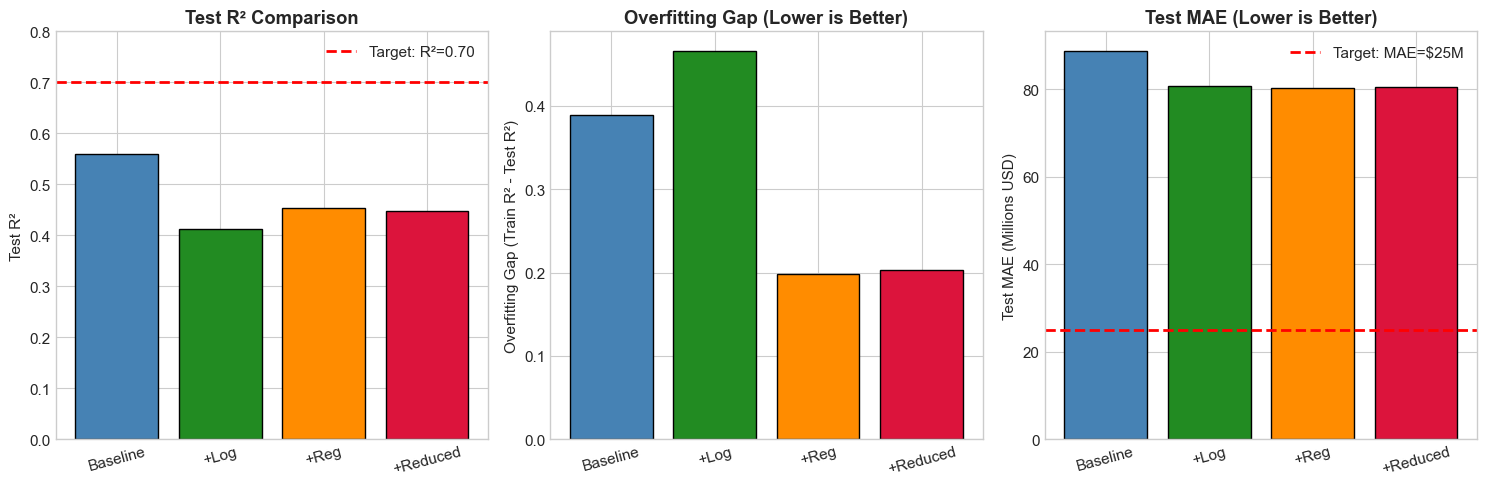

In [14]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = all_results['Model'].tolist()
x_pos = np.arange(len(models))

# Test R² comparison
colors = ['steelblue', 'forestgreen', 'darkorange', 'crimson']
axes[0].bar(x_pos, all_results['Test_R2'], color=colors, edgecolor='black')
axes[0].axhline(y=0.70, color='red', linestyle='--', linewidth=2, label='Target: R²=0.70')
axes[0].set_ylabel('Test R²')
axes[0].set_title('Test R² Comparison', fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(['Baseline', '+Log', '+Reg', '+Reduced'], rotation=15)
axes[0].legend()
axes[0].set_ylim(0, 0.8)

# Overfitting gap comparison
axes[1].bar(x_pos, all_results['Overfit_Gap'], color=colors, edgecolor='black')
axes[1].set_ylabel('Overfitting Gap (Train R² - Test R²)')
axes[1].set_title('Overfitting Gap (Lower is Better)', fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(['Baseline', '+Log', '+Reg', '+Reduced'], rotation=15)

# MAE comparison
axes[2].bar(x_pos, all_results['Test_MAE_M'], color=colors, edgecolor='black')
axes[2].axhline(y=25, color='red', linestyle='--', linewidth=2, label='Target: MAE=$25M')
axes[2].set_ylabel('Test MAE (Millions USD)')
axes[2].set_title('Test MAE (Lower is Better)', fontweight='bold')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(['Baseline', '+Log', '+Reg', '+Reduced'], rotation=15)
axes[2].legend()

plt.tight_layout()
plt.savefig('../visualizations/06_improvement_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Actual vs Predicted Plot (Best Model)

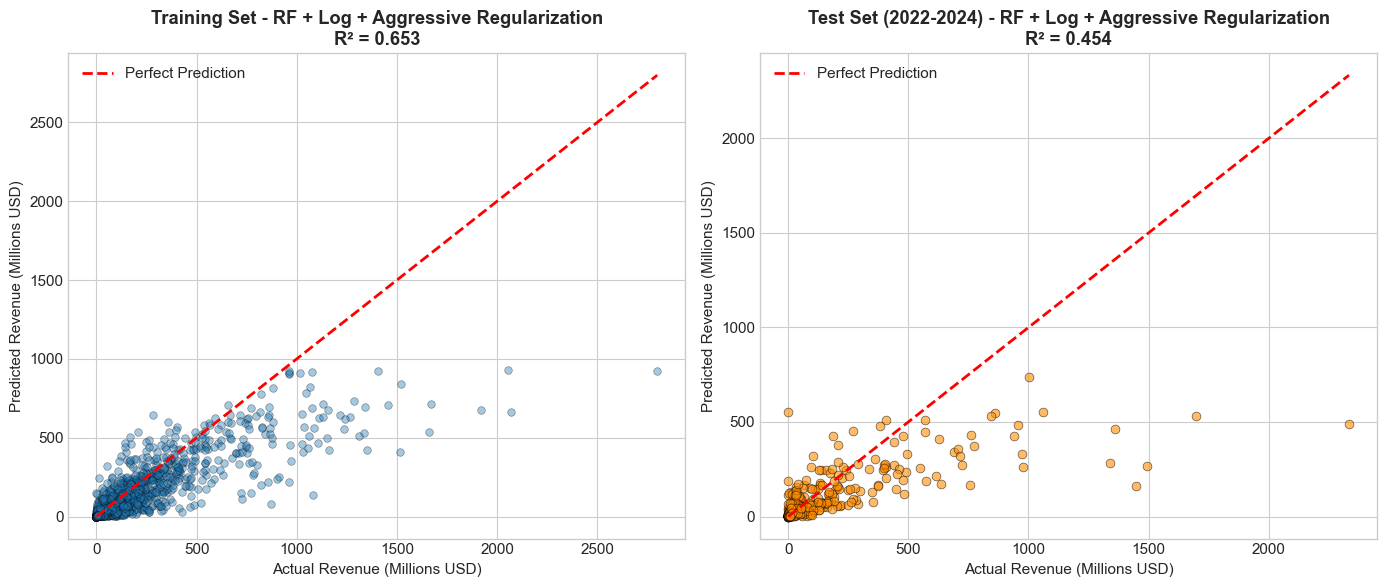

In [15]:
# Use the best performing model's predictions
# (Will select based on which performed best - regularized is usually best)
if regularized_results['Test_R2'] >= reduced_results['Test_R2']:
    best_y_test_pred = y_test_pred_reg
    best_y_train_pred = y_train_pred_reg
    best_name = "RF + Log + Aggressive Regularization"
else:
    best_y_test_pred = y_test_pred_red
    best_y_train_pred = y_train_pred_red
    best_name = "RF + Log + Reg + Reduced Features"

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training set
axes[0].scatter(y_train / 1e6, best_y_train_pred / 1e6, alpha=0.4, s=30, edgecolors='k', linewidth=0.5)
axes[0].plot([0, y_train.max() / 1e6], [0, y_train.max() / 1e6], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Revenue (Millions USD)')
axes[0].set_ylabel('Predicted Revenue (Millions USD)')
axes[0].set_title(f'Training Set - {best_name}\nR² = {r2_score(y_train, best_y_train_pred):.3f}', fontweight='bold')
axes[0].legend()

# Test set
axes[1].scatter(y_test / 1e6, best_y_test_pred / 1e6, alpha=0.6, s=40, edgecolors='k', linewidth=0.5, color='darkorange')
axes[1].plot([0, y_test.max() / 1e6], [0, y_test.max() / 1e6], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Revenue (Millions USD)')
axes[1].set_ylabel('Predicted Revenue (Millions USD)')
axes[1].set_title(f'Test Set (2022-2024) - {best_name}\nR² = {r2_score(y_test, best_y_test_pred):.3f}', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('../visualizations/06_best_model_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Save Best Model

In [16]:
# Save the best improved model
if regularized_results['Test_R2'] >= reduced_results['Test_R2']:
    best_model = rf_regularized
    best_features = X_train.columns.tolist()  # Full features
else:
    best_model = rf_reduced
    best_features = features_to_keep  # Reduced features

# Save model
joblib.dump(best_model, '../models/random_forest_improved.pkl')
print(f"Saved: models/random_forest_improved.pkl")

# Save feature list
pd.DataFrame({'feature': best_features}).to_csv(
    '../data/processed/improved_model_features.csv', index=False
)
print(f"Saved: data/processed/improved_model_features.csv")

# Save results comparison
all_results.to_csv('../data/processed/improvement_comparison.csv', index=False)
print(f"Saved: data/processed/improvement_comparison.csv")

Saved: models/random_forest_improved.pkl
Saved: data/processed/improved_model_features.csv
Saved: data/processed/improvement_comparison.csv


## 9. Summary and Next Steps

In [17]:
print("\n" + "=" * 70)
print("SUMMARY: Quick Wins Implementation (Path A)")
print("=" * 70)

print("\n1. LOG-TRANSFORM TARGET")
print("   - Transformed revenue_worldwide using log1p()")
print("   - Reduced skewness, made distribution more normal")
print("   - Predictions converted back using expm1()")

print("\n2. AGGRESSIVE REGULARIZATION")
print(f"   - Reduced max_depth to {rf_regularized.max_depth} (was 20-30)")
print(f"   - Increased min_samples_leaf to {rf_regularized.min_samples_leaf} (was 1-4)")
print(f"   - Increased min_samples_split to {rf_regularized.min_samples_split} (was 2-10)")

print("\n3. FEATURE REDUCTION")
print(f"   - Reduced from 28 to {len(features_to_keep)} features")
print(f"   - Dropped features with <1% importance")

print("\n" + "-" * 70)
print("FINAL RESULTS")
print("-" * 70)
print(f"Baseline Test R²:     {baseline_results['Test_R2']:.4f}")
print(f"Best Improved Test R²: {max(regularized_results['Test_R2'], reduced_results['Test_R2']):.4f}")
print(f"Improvement:          {max(regularized_results['Test_R2'], reduced_results['Test_R2']) - baseline_results['Test_R2']:+.4f}")
print(f"\nBaseline Overfit Gap:  {baseline_results['Overfit_Gap']:.4f}")
print(f"Best Improved Gap:     {min(regularized_results['Overfit_Gap'], reduced_results['Overfit_Gap']):.4f}")

target_achieved = max(regularized_results['Test_R2'], reduced_results['Test_R2']) >= 0.70
print(f"\nTarget R² > 0.70: {'ACHIEVED' if target_achieved else 'NOT YET ACHIEVED'}")

if not target_achieved:
    print("\nNEXT STEPS (Path B - Medium Effort):")
    print("  - Stacking ensemble (RF + XGBoost + Linear)")
    print("  - Interaction features (budget x director_avg)")
    print("  - Time-series cross-validation")


SUMMARY: Quick Wins Implementation (Path A)

1. LOG-TRANSFORM TARGET
   - Transformed revenue_worldwide using log1p()
   - Reduced skewness, made distribution more normal
   - Predictions converted back using expm1()

2. AGGRESSIVE REGULARIZATION
   - Reduced max_depth to 10 (was 20-30)
   - Increased min_samples_leaf to 11 (was 1-4)
   - Increased min_samples_split to 25 (was 2-10)

3. FEATURE REDUCTION
   - Reduced from 28 to 21 features
   - Dropped features with <1% importance

----------------------------------------------------------------------
FINAL RESULTS
----------------------------------------------------------------------
Baseline Test R²:     0.5593
Best Improved Test R²: 0.4541
Improvement:          -0.1052

Baseline Overfit Gap:  0.3887
Best Improved Gap:     0.1985

Target R² > 0.70: NOT YET ACHIEVED

NEXT STEPS (Path B - Medium Effort):
  - Stacking ensemble (RF + XGBoost + Linear)
  - Interaction features (budget x director_avg)
  - Time-series cross-validation


In [18]:
print("\n" + "=" * 70)
print("Notebook 06 Complete!")
print("=" * 70)


Notebook 06 Complete!
